In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV,GridSearchCV
import seaborn as sns 

In [2]:
df = pd.read_csv('./BankChurners.csv')
print("There are {} records in dataset".format(len(df)))
print("There are {} attributes".format(len(df.columns)))

There are 10127 records in dataset
There are 23 attributes


In order to get familiar with this dataset, I do data checking first  

In [3]:
print(df.isna().sum())

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [4]:
print(df.dtypes)

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

Attrition Flag is out target variable we want to predict. Therefore, I explore the percentage of the existing customer 
and attrited customer firstly

In [5]:
attrition_pect = len(df[df['Attrition_Flag'] == 'Attrited Customer']) / len(df)
existing_pect = len(df[df['Attrition_Flag'] == 'Existing Customer']) / len(df)
print("The pecentage of attrited customer is ", f"{attrition_pect * 100:.2f}%")
print("The pecentage of existing cusomter is ", f"{existing_pect * 100:.2f}%")

The pecentage of attrited customer is  16.07%
The pecentage of existing cusomter is  83.93%


<ipython-input-6-47d77a706fa9>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  rects = plt.axes().patches


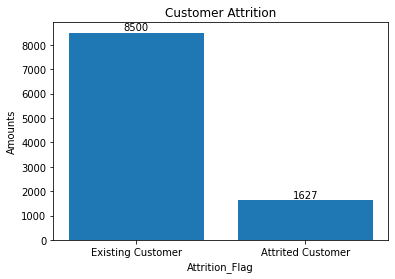

In [6]:
ser = df['Attrition_Flag'].value_counts()
plt.bar(ser.index, ser.values)
plt.xlabel('Attrition_Flag')
plt.ylabel('Amounts')
plt.title('Customer Attrition')
rects = plt.axes().patches
ax = plt.gca()
for rect, label in zip(rects, ser.values):
   height = rect.get_height()
   ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, 
   ha='center', va='bottom')

This is an imbalance data

<ipython-input-7-bdedc9ce15d0>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  rects = plt.axes().patches


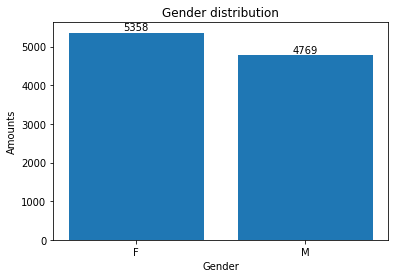

In [7]:
gender_df = pd.DataFrame(df.groupby(['Gender']).size(), columns = ['total'])
plt.bar(gender_df.index, gender_df['total'].values)
plt.xlabel('Gender')
plt.ylabel('Amounts')
plt.title('Gender distribution')
rects = plt.axes().patches
ax = plt.gca()
for rect, label in zip(rects, gender_df['total'].values):
   height = rect.get_height()
   ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, 
   ha='center', va='bottom')

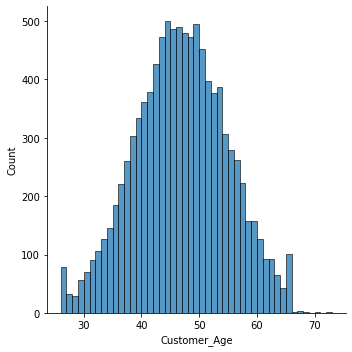

In [8]:
sns.displot(df['Customer_Age'])

In [9]:
#Correlation of each attributes
revamp_df = df.drop(columns=['CLIENTNUM'])
# rename the navie bayes columns name
revamp_df.rename(columns = {"Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1":"Naive_Bayes_mon_1"}, inplace=True)
revamp_df.rename(columns = {"Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2":"Naive_Bayes_mon_2"}, inplace=True)

In [10]:
category_columns = revamp_df.select_dtypes(include='object').columns
print(category_columns)

Index(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category'],
      dtype='object')


Therefore, I have to encode those column values. But before I do this, I have to know the categories of each target column.


In [11]:
for category in category_columns:
    print(category)
    print(revamp_df[category].value_counts())


Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
Gender
F    5358
M    4769
Name: Gender, dtype: int64
Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


In [14]:
label = ['Attrition_Flag', 'Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
le = LabelEncoder()
revamp_df[label] = revamp_df[label].apply(lambda x : le.fit_transform(x))
print(revamp_df[label].head(10))   
print("Attrition_Flag Column value 1 means Existing Customer and 0 means Attrited Customer")

   Attrition_Flag  Gender  Education_Level  Marital_Status  Income_Category  \
0               1       1                3               1                2   
1               1       0                2               2                4   
2               1       1                2               1                3   
3               1       0                3               3                4   
4               1       1                5               1                2   
5               1       1                2               1                1   
6               1       1                6               1                0   
7               1       1                3               3                2   
8               1       1                5               2                2   
9               1       1                2               2                3   

   Card_Category  
0              0  
1              0  
2              0  
3              0  
4              0  
5              0

The I analyze the correlation between each feature and find the contribution to the attrited customer 

In [13]:
df_corr =revamp_df.corr()
df_corr.sort_values(['Attrition_Flag'], ascending=False, inplace = True)
print(df_corr['Attrition_Flag'])


Attrition_Flag              1.000000
Naive_Bayes_mon_2           0.999989
Total_Trans_Ct              0.371403
Total_Ct_Chng_Q4_Q1         0.290054
Total_Revolving_Bal         0.263053
Avg_Utilization_Ratio       0.178410
Total_Trans_Amt             0.168598
Total_Relationship_Count    0.150005
Total_Amt_Chng_Q4_Q1        0.131063
Gender                      0.037272
Credit_Limit                0.023873
Card_Category               0.006038
Avg_Open_To_Buy             0.000285
Education_Level            -0.005551
Months_on_book             -0.013687
Income_Category            -0.017584
Customer_Age               -0.018203
Marital_Status             -0.018597
Dependent_count            -0.018991
Months_Inactive_12_mon     -0.152449
Contacts_Count_12_mon      -0.204491
Naive_Bayes_mon_1          -0.999989
Name: Attrition_Flag, dtype: float64


From the above example, Naive_Bayes_mon_2 and Total_Trans_Ct have are the top 2 feature which has positive correlation
with Attrition_Flag. Naive_Bayes_mon_1 and Contacts_Count_12_mon are the top 2 feature which has negative correlation
to Attrition_Flag. Avg_Open_To_Buy has near zero impact to Attrition_Flag.

<AxesSubplot:>

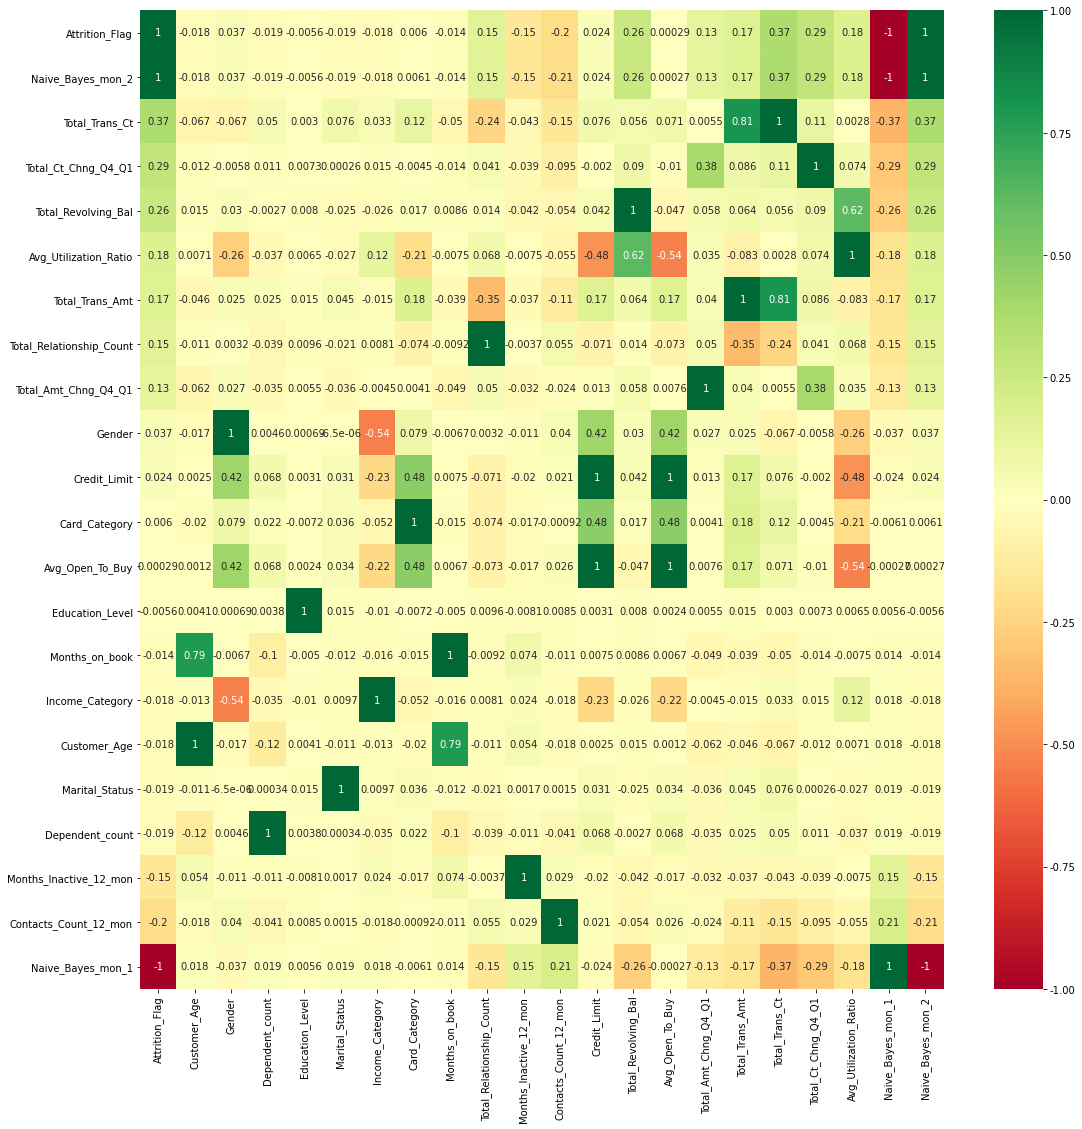

In [14]:
#Then I draw a heatmap to visualize the corrleation result 
plt.figure(figsize=(18,18))
sns.heatmap(df_corr, annot=True, cmap='RdYlGn')

In [15]:
#Since the avg_open_to_buy has near zero power to influence customer churn or not churn. Therefore, I remove it 
#from dataset
revamp_df.drop(columns = 'Avg_Open_To_Buy', inplace = True)

Finally, I get the useful dataset after doing the basic analysis and data wrangling

According to the first part of data analysis, the attrited customer occupied the small proportion of dataset. 
This dataset is possible imbalance data. In the following part, I split the data to 70% and 30%. 70% is training set 
and 30% is test set. I use Decision Tree model to do the prediction.

In [17]:
X = revamp_df.drop(columns =['Attrition_Flag'])
y = revamp_df['Attrition_Flag']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [19]:
model = DecisionTreeClassifier(ccp_alpha=0.01)

Decision Tree classifier show as follows
The accuracy socre is  1.0
Report shows as follows:
                   precision    recall  f1-score   support

Attrited Customer       1.00      1.00      1.00       456
Existing Customer       1.00      1.00      1.00      2583

         accuracy                           1.00      3039
        macro avg       1.00      1.00      1.00      3039
     weighted avg       1.00      1.00      1.00      3039

Decision Tree confusion matrix


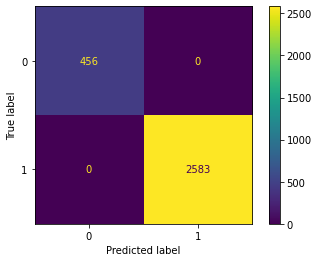

In [20]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Decision Tree classifier show as follows")
print("The accuracy socre is ", accuracy_score(y_test, y_pred))
print("Report shows as follows:")
print(classification_report(y_test, y_pred, target_names = ['Attrited Customer', 'Existing Customer']))
print("Decision Tree confusion matrix")
plot_confusion_matrix(model, X_test, y_test)

In [21]:
#The F1 score is 1. It is an imbalance dataset.

Because it is an imbalance data, the model is overfitting now. 

RandomForest result show as follows
The accuracy socre is  1.0
Report shows as follows:
                   precision    recall  f1-score   support

Attrited Customer       1.00      1.00      1.00       456
Existing Customer       1.00      1.00      1.00      2583

         accuracy                           1.00      3039
        macro avg       1.00      1.00      1.00      3039
     weighted avg       1.00      1.00      1.00      3039

Random Forest confusion matrix


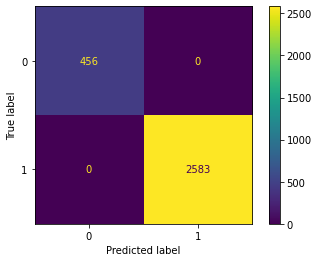

In [22]:
model = RandomForestClassifier(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RandomForest result show as follows")
print("The accuracy socre is ", accuracy_score(y_test, y_pred))
print("Report shows as follows:")
print(classification_report(y_test, y_pred, target_names = ['Attrited Customer', 'Existing Customer']))
print("Random Forest confusion matrix")
plot_confusion_matrix(model, X_test, y_test)

Gradient boosting classifier result show as follows
The accuracy socre is  1.0
Report shows as follows:
                   precision    recall  f1-score   support

Attrited Customer       1.00      1.00      1.00       456
Existing Customer       1.00      1.00      1.00      2583

         accuracy                           1.00      3039
        macro avg       1.00      1.00      1.00      3039
     weighted avg       1.00      1.00      1.00      3039

Gradien boosting confusion matrix


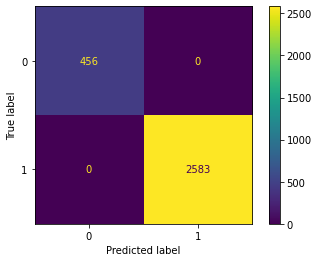

In [23]:
model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, random_state =0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Gradient boosting classifier result show as follows")
print("The accuracy socre is ", accuracy_score(y_test, y_pred))
print("Report shows as follows:")
print(classification_report(y_test, y_pred, target_names = ['Attrited Customer', 'Existing Customer']))
print("Gradien boosting confusion matrix")
plot_confusion_matrix(model, X_test, y_test)

SVM result show as follows
The accuracy socre is  0.3705166173083251
Report shows as follows:
                   precision    recall  f1-score   support

Attrited Customer       0.07      0.27      0.11       456
Existing Customer       0.75      0.39      0.51      2583

         accuracy                           0.37      3039
        macro avg       0.41      0.33      0.31      3039
     weighted avg       0.65      0.37      0.45      3039

SVM confusion matrix


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


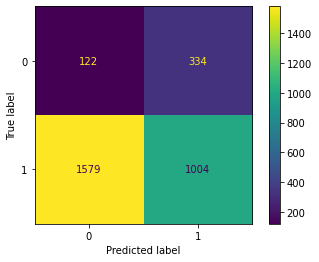

In [24]:
model = SVC(kernel='linear', C=10, max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("SVM result show as follows")
print("The accuracy socre is ", accuracy_score(y_test, y_pred))
print("Report shows as follows:")
print(classification_report(y_test, y_pred, target_names = ['Attrited Customer', 'Existing Customer']))
print("SVM confusion matrix")
plot_confusion_matrix(model, X_test, y_test)

KNeighbors classifier result show as follows
The accuracy socre is  0.8552155314248108
Report shows as follows:
                   precision    recall  f1-score   support

Attrited Customer       0.51      0.73      0.60       456
Existing Customer       0.95      0.88      0.91      2583

         accuracy                           0.86      3039
        macro avg       0.73      0.80      0.76      3039
     weighted avg       0.88      0.86      0.87      3039

KNeighbors confusion matrix


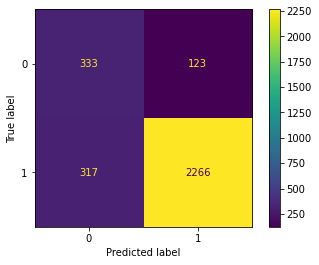

In [31]:
model = KNeighborsClassifier(n_neighbors =2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("KNeighbors classifier result show as follows")
print("The accuracy socre is ", accuracy_score(y_test, y_pred))
print("Report shows as follows:")
print(classification_report(y_test, y_pred, target_names = ['Attrited Customer', 'Existing Customer']))
print("KNeighbors confusion matrix")
plot_confusion_matrix(model, X_test, y_test)